In [ ]:
Optimizing the ridge regression parameter

In [2]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=100, n_features=2, effective_rank=1, noise=10)

from sklearn.linear_model import RidgeCV
rcv = RidgeCV(alphas=np.array([.1, .2, .3, .4]))
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [3]:
rcv.alpha_

0.29999999999999999

In [4]:
rcv2 = RidgeCV(alphas=np.array([.08, .09, .1, .11, .12]))
rcv2.fit(reg_data, reg_target)
rcv2.alpha_

0.12

In [5]:
alphas_to_test = np.linspace(0.01, 1)
rcv3 = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv3.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.5151 ...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [6]:
rcv3.cv_values_.shape

(100L, 50L)

In [7]:
smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

0.29285714285714287

In [8]:
rcv3.alpha_

0.29285714285714287

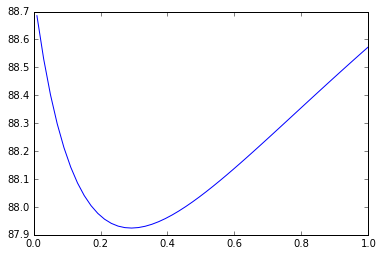

In [12]:
%matplotlib inline
plt.plot(alphas_to_test, rcv3.cv_values_.mean(axis=0))

In [13]:
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import make_scorer
MAD_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rcv4 = RidgeCV(alphas=alphas_to_test, store_cv_values=True, scoring=MAD_scorer)
rcv4.fit(reg_data, reg_target)
smallest_idx = rcv4.cv_values_.mean(axis=0).argmin()

In [14]:
rcv4.cv_values_.mean(axis=0)[smallest_idx]

0.00070580517282746945

In [15]:
alphas_to_test[smallest_idx]

1.0

In [17]:
X = np.linspace(0, 5)
y_truth = 3 * X
y_noise = np.random.normal(0, 0.5, len(y_truth)) #normally distributed noise with mean 0 and spread 0.1
y_noisy = (y_truth + y_noise)


from sklearn.linear_model import BayesianRidge
br_inst = BayesianRidge().fit(X.reshape(-1, 1), y_noisy)

<Container object of 3 artists>

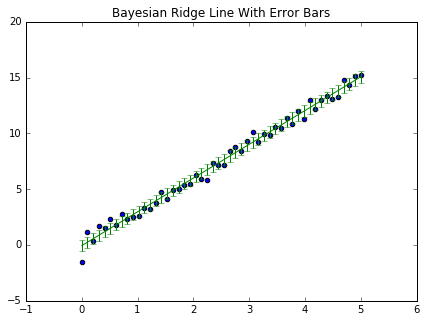

In [18]:
y_pred, y_err = br_inst.predict(X.reshape(-1, 1), return_std=True)

plt.figure(figsize=(7, 5))
plt.scatter(X, y_noisy)
plt.title("Bayesian Ridge Line With Error Bars")
plt.errorbar(X, y_pred, y_err, color='green')

In [ ]:
y_pred, y_err = br_inst.predict(X.reshape(-1, 1), return_std=True)

plt.figure(figsize=(7, 5))
plt.scatter(X, y_noisy)
plt.title("Bayesian Ridge Line With Error Bars")
plt.errorbar(X, y_pred, y_err, color='green')
















As a final aside on BayesianRidge, you can perform hyper-parameter optimization on the parameters alpha_1, alpha_2, lambda_1, and lambda_2 using a cross-validated grid search.

Using sparsity to regularize models

The least absolute shrinkage and selection operator (LASSO) method is very similar to ridge regression and LARS. It's similar to Ridge Regression in the sense that we penalize our regression by some amount, and it's similar to LARS in that it can be used as a parameter selection, and it typically leads to a sparse vector of coefficients.

Getting ready

To be clear, lasso regression is not a panacea. There can be computation consequences to using lasso regression. As we'll see in this recipe, we'll use a loss function that isn't differential, and therefore, requires special, and more importantly, performance-impairing workarounds.

How to do it...

Let's go back to the trusty make_regression function and create a dataset with the same parameters:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200, n_features=500, n_informative=5, noise=5)
Next, we need to import the Lasso object:
from sklearn.linear_model import Lasso
lasso = Lasso()
Lasso contains many parameters, but the most interesting parameter is alpha. It scales the penalization term of the Lasso method. For now, leave it as 1. As an aside, and much like ridge regression, if this term is 0, lasso is equivalent to linear regression:
lasso.fit(reg_data, reg_target)
Again, let's see how many of the coefficients remain nonzero:
np.sum(lasso.coef_ != 0)
7
lasso_0 = Lasso(0)
lasso_0.fit(reg_data, reg_target)
np.sum(lasso_0.coef_ != 0)
500
None of our coefficients turn out to be 0, which is what we expect. Actually, if you run this, you might get a warning from scikit-learn that advises you to choose LinearRegression.

How it works...

Lasso cross-validation

Choosing the most appropriate lambda is a critical problem. We can specify the lambda ourselves or use cross-validation to find the best choice given the data at hand:

from sklearn.linear_model import LassoCV
lassocv = LassoCV()
lassocv.fit(reg_data, reg_target)
lassocv will have, as an attribute, the most appropriate lambda. scikit-learn mostly uses alpha in its notation, but the literature uses lambda:

 lassocv.alpha_
0.75182924196508782
The number of coefficients can be accessed in the regular manner:

lassocv.coef_[:5]
array([-0., -0.,  0.,  0., -0.])
Letting lassocv choose the appropriate best fit leaves us with 11 nonzero coefficients:

np.sum(lassocv.coef_ != 0)
15
Lasso for feature selection

Lasso can often be used for feature selection for other methods. For example, you might run lasso regression to get the appropriate number of features, and then use these features in another algorithm.

To get the features we want, create a masking array based on the columns that aren't zero, and then filter to keep the features we want:


mask = lassocv.coef_ != 0
new_reg_data = reg_data[:, mask]
new_reg_data.shape
(200L, 15L)
Taking a more fundame